# MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications

### Imports

In [21]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Prepare the Dataset: CIFAR-10

In [4]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normallize images to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
print(len(x_train), len(x_val), len(x_test))

40000 10000 10000


In [6]:
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

In [7]:
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess_dataset)
train_dataset = train_dataset.shuffle(1000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(-1)

In [8]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(preprocess_dataset)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.repeat()

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess_dataset)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.repeat()

## MobileNetV1

#### Depth-wise Separable Convolution


<div align="center">

  <img alt="Depthwise conv" src="./assets/depthwise_conv.png" width=800 height=250/>
  <br/>
  <figcaption>Figure 1: Depth-wise Separable Convolution</figcaption>

</div>

In [10]:
def depthwise_separable_conv(inputs, filters, alpha, s=1):
    """
    Depth-wise + Point-wise Convolutions

    Args:
        inputs (tensor): input tensor
        filters (int): number of output channels
        alpha (float): scale factor between 0 and 1. for the number of output channels
        s (int): strides
    """
    # depth-wise convolution (3x3)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), padding="same", strides=(s, s))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    # point-wise (1x1 conv)
    x = tf.keras.layers.Conv2D(int(filters * alpha), kernel_size=(1, 1), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

#### MobileNetV1 Model

In [11]:
def mobilenet_v1(input_shape, n_classes, alpha=1.0, rho=1.0):
    """
    Args:
        input_shape (tuple): input shape (H, W, C)
        n_classes (int): number of classes
        alpha (float): with multiplier (scales channels)
        rho (float): resolution factor (scales input size)
    """

    # scale input shape by rho
    input_shape = (int(input_shape[0] * rho), int(input_shape[1] * rho), input_shape[2])
    inputs = tf.keras.layers.Input(shape=input_shape)

    # initial normal convolution
    x = tf.keras.layers.Conv2D(int(32 * alpha), (3, 3), strides=(2, 2), padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    # depth-wise separable blocks
    x = depthwise_separable_conv(x, 64, alpha, s=1)
    x = depthwise_separable_conv(x, 128, alpha, s=2)
    x = depthwise_separable_conv(x, 128, alpha, s=1)
    x = depthwise_separable_conv(x, 256, alpha, s=2)
    x = depthwise_separable_conv(x, 256, alpha, s=1)
    x = depthwise_separable_conv(x, 512, alpha, s=2)

    for _ in range(5):
        x = depthwise_separable_conv(x, 512, alpha, s=1)

    x = depthwise_separable_conv(x, 1024, alpha, s=2)
    x = depthwise_separable_conv(x, 1024, alpha, s=1)

    # global average pooling and fc
    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name="MobileNetV1")

    return model

#### Model Summary

In [12]:
input_shape = (224, 224, 3)
n_classes = 10

model = mobilenet_v1(input_shape, n_classes, alpha=1.0, rho=1.0)
model.summary()

Model: "MobileNetV1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 112, 112, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 56, 56, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 56, 56, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,250,058 (12.40 MB)

 Trainable params: 3,228,170 (12.31 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Compile the Model

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Train the Model

#### Checkpoint callback

In [14]:
checkpoint_path = "/checkpoints/mobilenet_v1.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# model.load_weights("/checkpoints/mobilenet_v1.weights.h5")

Num GPUs Available:  1


#### Model fit

In [16]:
EPOCHS = 10

train_length = len(x_train)
val_length = len(x_val)

val_subsplits = 1
steps_per_epoch = train_length // BATCH_SIZE
validation_steps = val_length // BATCH_SIZE // val_subsplits

In [19]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3539 - loss: 1.7634
Epoch 1: val_loss improved from inf to 2.74822, saving model to /checkpoints/mobilenet_v1.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 137ms/step - accuracy: 0.3540 - loss: 1.7630 - val_accuracy: 0.1998 - val_loss: 2.7482
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6248 - loss: 1.0549
Epoch 2: val_loss improved from 2.74822 to 1.67761, saving model to /checkpoints/mobilenet_v1.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.6249 - loss: 1.0548 - val_accuracy: 0.4988 - val_loss: 1.6776
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7390 - loss: 0.7510
Epoch 3: val_loss improved from 1.67761 to 1.17605, saving model to /checkpoints/mobilenet_v1.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.7390 - loss: 0.7509 - val_accuracy: 0.6633 - val_loss: 1.1761
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy

### Evaluate the Model

In [22]:
def plot_history(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, "bo-", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.legend()

    plt.show()

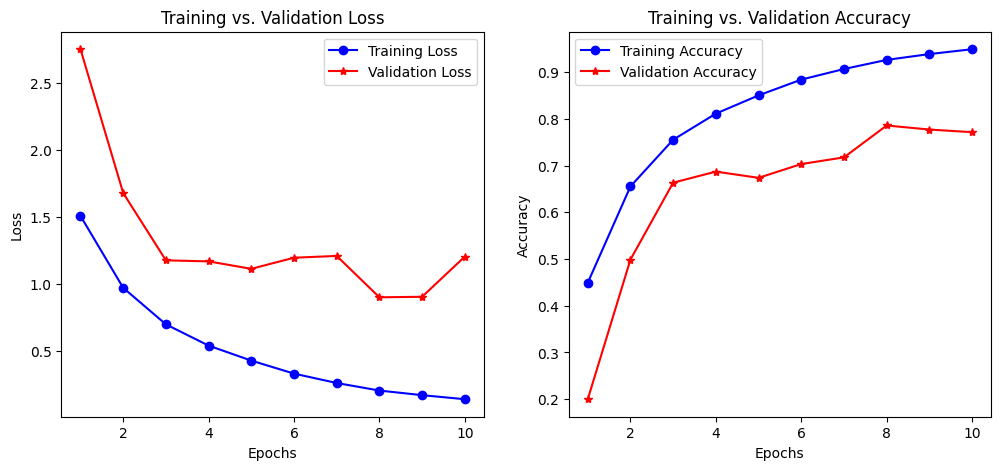

In [23]:
plot_history(history)

In [25]:
test_length = len(x_test)

loss, accuracy = model.evaluate(test_dataset, steps= test_length // BATCH_SIZE, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")

156/156 - 5s - 33ms/step - accuracy: 0.7715 - loss: 1.2039
Test Accuracy: 0.7715
